In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from model_settings import ms
from df_collector import df_collector
pd.set_option("display.max_columns",0)
pd.options.display.float_format = '{:.6f}'.format
root = Path().resolve().parent.parent
df_collector.root = root
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}")


##################
# training start #
##################

Wed Nov 27 01:33:41 2024


# loading data

In [2]:
data = df_collector.cboe_spx_barriers().iloc[:,1:]
pricename = [f for f in data.columns if f.find('_price')!=-1 and f.find('spot_')==-1 and f.find('strike_')==-1][0]
relative_pricename = 'relative_'+pricename
data = data[data[pricename]<=data['spot_price']]
print(f'collected {pricename[:pricename.find('_',0)]} options')
print(data.describe())
print(data.dtypes)
print(data['calculation_date'].drop_duplicates().reset_index(drop=True))

collected barrier options
          spot_price   strike_price        barrier  days_to_maturity         rebate  dividend_rate  risk_free_rate          theta          kappa            rho            eta             v0  barrier_price
count 3847361.000000 3847361.000000 3847361.000000    3847361.000000 3847361.000000 3847361.000000  3847361.000000 3847361.000000 3847361.000000 3847361.000000 3847361.000000 3847361.000000 3847361.000000
mean     2892.177635    2892.186715    2903.957464        323.569280       0.000000       0.018553        0.014456       0.116187       6.667757      -0.789923       1.908828       0.058822     136.927073
std      1141.565939    1159.089050    1491.468099        241.000899       0.000000       0.002738        0.017106       0.181990      10.254707       0.144445       1.927975       0.086581     275.860780
min      1274.000000    1146.600000     637.000000         60.000000       0.000000       0.012624        0.000330       0.000000       0.000000      -1.0

In [3]:
filetag = f'cboe spx relative {pricename[:pricename.find('_',0)]}'

In [4]:
data[pricename].describe()

count   3847361.000000
mean        136.927073
std         275.860780
min           0.000000
25%           0.867783
50%          33.569416
75%         154.128350
max        5424.825644
Name: barrier_price, dtype: float64

# data cleaning & preparation

In [5]:
data_strikes = data['strike_price']
data['relative_spot'] = data['spot_price']/data_strikes
data[relative_pricename] = data[pricename]/data_strikes
try:
    data['relative_barrier'] = data['barrier']/data_strikes
    data['relative_rebate'] = data['rebate']/data_strikes
except Exception:
    pass

data['calculation_date'] = pd.to_datetime(data['calculation_date'],format='mixed')
data['date'] = pd.to_datetime(data['date'],format='mixed')
data.dtypes

spot_price                       float64
strike_price                     float64
barrier                          float64
days_to_maturity                   int64
updown                            object
outin                             object
w                                 object
barrier_type_name                 object
rebate                           float64
dividend_rate                    float64
risk_free_rate                   float64
theta                            float64
kappa                            float64
rho                              float64
eta                              float64
v0                               float64
calculation_date          datetime64[ns]
date                      datetime64[ns]
barrier_price                    float64
relative_spot                    float64
relative_barrier_price           float64
relative_barrier                 float64
relative_rebate                  float64
dtype: object

In [6]:
def noisify(x):
    return x + np.random.normal(scale=x*0.01)

relative_observed = data[relative_pricename].values
relative_observed[relative_observed>0] = noisify(relative_observed[relative_observed>0])
targetname = 'relative_observed'
data[targetname]= relative_observed
data[targetname].describe()

count   3847361.000000
mean          0.048787
std           0.095493
min           0.000000
25%           0.000336
50%           0.012646
75%           0.059574
max           1.091845
Name: relative_observed, dtype: float64

# visualization

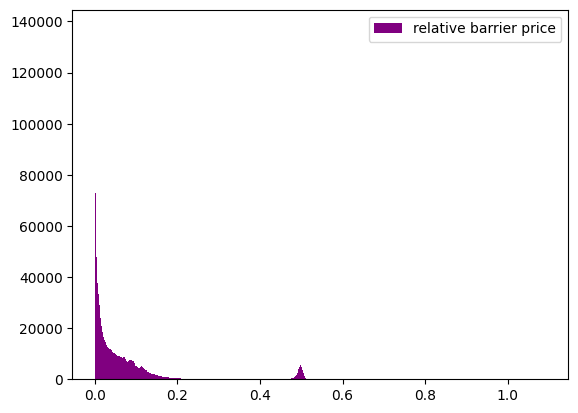

count   2830088.000000
mean          0.066300
std           0.106004
min           0.000500
25%           0.008461
50%           0.031847
75%           0.079463
max           1.091845
Name: relative_observed, dtype: float64

In [7]:
"""
plot
"""
rels = data[targetname]
rels = rels[rels>0.0005]
plt.figure()
plt.hist(rels,color='purple',label=relative_pricename.replace('_',' '),bins=int(np.sqrt(len(rels))))
plt.legend()
plt.show()
rels.describe()

['spot_price', 'kappa', 'theta', 'rho', 'eta', 'v0', 'risk_free_rate', 'dividend_rate', 'relative_barrier_price', 'spot_price']


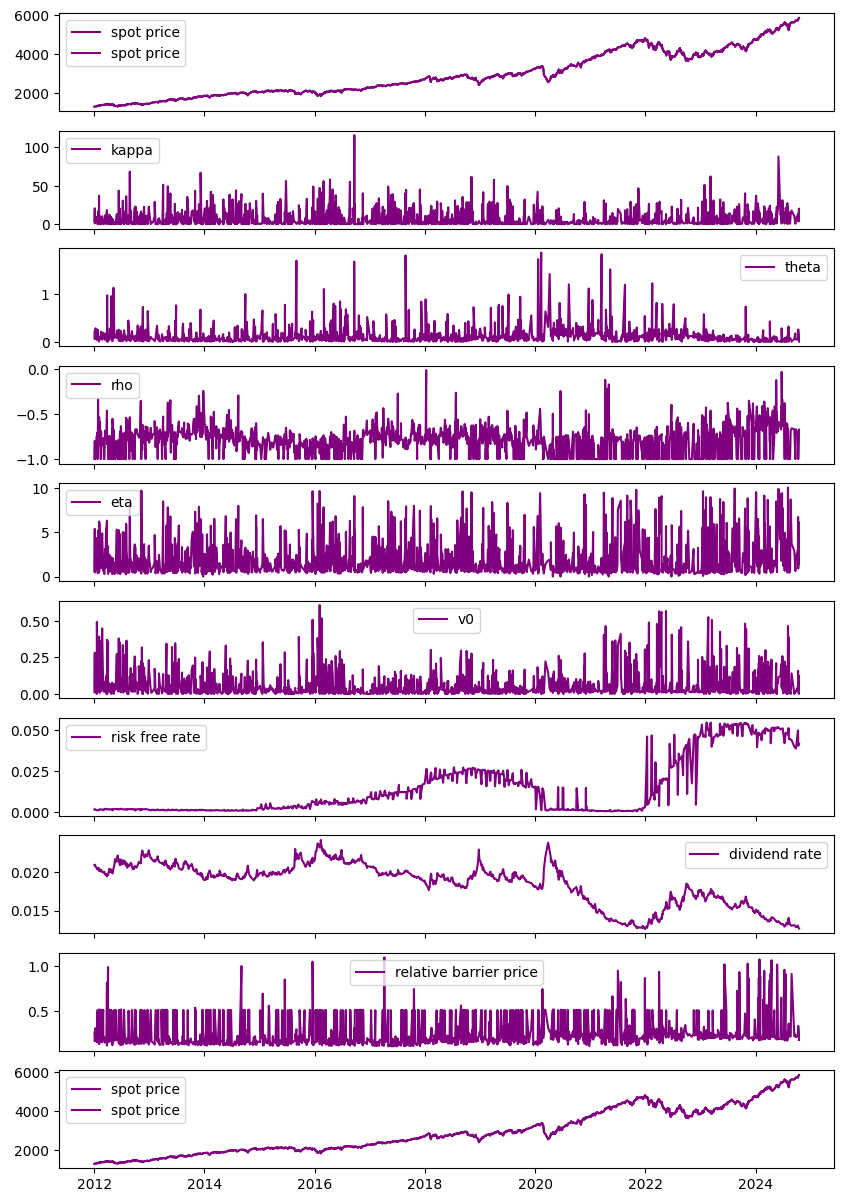

where 'relative_barrier_price' is the maximum market observed relative barrier option price


count   3847361.000000
mean          0.048787
std           0.095493
min           0.000000
25%           0.000336
50%           0.012646
75%           0.059574
max           1.091845
Name: relative_barrier_price, dtype: float64

In [8]:
from plotters import PlotCols
col_names = ['spot_price','kappa','theta','rho','eta','v0','risk_free_rate','dividend_rate',relative_pricename,'spot_price']
index = 'calculation_date'
plot_data = data[col_names+[index]].copy().sort_values(by=relative_pricename).drop_duplicates(subset=index,keep='last').sort_values(by=index).reset_index(drop=True)
data_cols = [index] + col_names
PlotCols(
    plot_data,
    col_names=col_names,
    index=index,
    figsize=(10,15)
)
print(f"where '{relative_pricename}' is the maximum market observed relative {pricename[:pricename.find('_',0)]} option price")
pd.Series(plot_data[index])
data[relative_pricename].describe()

# training procedure

## model parameterization and initializaiton

In [9]:
from convsklearn import convsklearn
trainer = convsklearn()
trainer.target_name = targetname
trainer.excluded_features = trainer.excluded_features + ['spot_price','strike_price','barrier','rebate',relative_pricename,'relative_observed']
trainer.__dict__

{'seed': 1312,
 'raw_data': Empty DataFrame
 Columns: []
 Index: [],
 'dataset': Empty DataFrame
 Columns: []
 Index: [],
 'target_name': 'relative_observed',
 'excluded_features': ['barrier_price',
  'asian_price',
  'observed_price',
  'outin',
  'updown',
  'n_fixings',
  'spot_price',
  'strike_price',
  'barrier',
  'rebate',
  'relative_barrier_price',
  'relative_observed'],
 'numerical_features': [],
 'categorical_features': [],
 'feature_set': [],
 'n_features': 0,
 'development_dates': {},
 'test_dates': {},
 'train_data': {},
 'test_data': {},
 'train_X': {},
 'train_y': {},
 'test_X': {},
 'test_y': {},
 'preprocessor': None,
 'pipeline': None,
 'model': None,
 'fitted': None,
 'runtime': 0,
 'numerical_scaler': StandardScaler()}

In [11]:
trainer.load_data(data)
print('features:')
for f in trainer.feature_set:
    print(f"   {f}")
print(f"\ntarget:\n   {trainer.target_name}")
print(trainer.mlp_params)

features:
   days_to_maturity
   dividend_rate
   risk_free_rate
   theta
   kappa
   rho
   eta
   v0
   relative_spot
   relative_barrier
   relative_rebate
   w
   barrier_type_name

target:
   relative_observed
{'hidden_layer_sizes': (13, 13), 'random_state': 1312}


In [12]:
dates = data['date'].drop_duplicates()

## prepocessing

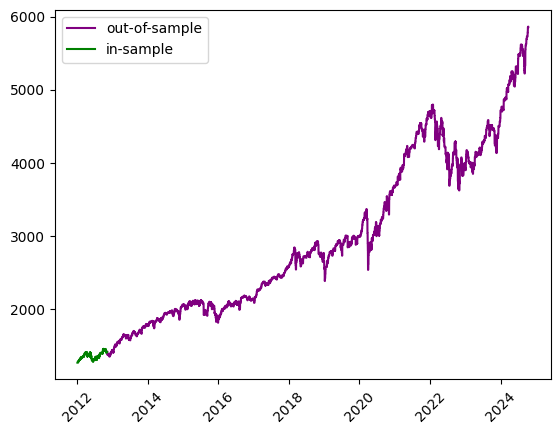

In [13]:
development_dates = dates[:100]#len(dates)//3]
test_dates = dates[~dates.isin(development_dates)]
trainer.preprocess_data(development_dates,test_dates)

## training

In [14]:
trainer.fit_mlp()


training on 266781 samples...

hidden_layer_sizes: (13, 13)
random_state: 1312
cpu: 8.133814096450806


In [15]:
print('instance variables:')

for key, value in trainer.__dict__.items():
    print(f"{key}:\n  {value}\n")

instance variables:
seed:
  1312

raw_data:
           spot_price  strike_price     barrier  days_to_maturity updown outin     w  ...       date  barrier_price  relative_spot  relative_barrier_price  relative_barrier  relative_rebate  relative_observed
0       1274.000000   1146.600000  637.000000                60   Down   Out  call  ... 2012-01-03     135.143405       1.111111                0.118540          0.555556         0.000000           0.118540
1       1274.000000   1146.600000  637.000000                60   Down   Out   put  ... 2012-01-03      11.783221       1.111111                0.010494          0.555556         0.000000           0.010494
2       1274.000000   1146.600000  637.000000                60   Down    In  call  ... 2012-01-03       0.066615       1.111111                0.000058          0.555556         0.000000           0.000058
3       1274.000000   1146.600000  637.000000                60   Down    In   put  ... 2012-01-03       0.012142       1.1111

## testing

In [16]:
train_test = trainer.test_prediction_accuracy()


in sample:
     RMSE: 0.022364148372279773
     MAE: 0.014680726612329803

out of sample:
     RMSE: 0.5331181695714262
     MAE: 0.310283809819333


In [17]:
trainer.model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('StandardScaler',
                                                  StandardScaler(),
                                                  ['days_to_maturity',
                                                   'dividend_rate',
                                                   'risk_free_rate', 'theta',
                                                   'kappa', 'rho', 'eta', 'v0',
                                                   'relative_spot',
                                                   'relative_barrier',
                                                   'relative_rebate']),
                                                 ('OneHotEncoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['w',
                                                   'barrier_type_name'])])),
                ('regressor',
                 MLPRegressor(hidden_layer_sizes=(13, 13), random_state=1312))])

In [18]:
oserr = trainer.test_data['outofsample_error']
iserr = trainer.train_data['insample_error']

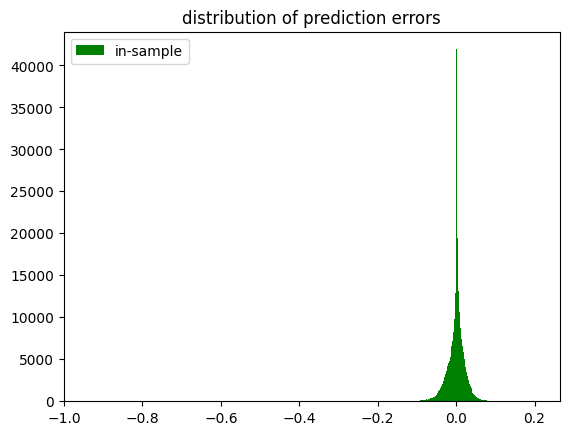

In [19]:
plt.figure()
# plt.hist(oserr,color='purple',label='out-of-sample',bins=int(np.sqrt(len(oserr))))
plt.hist(iserr,color='green',label='in-sample',bins=int(np.sqrt(len(iserr))))
plt.legend()
plt.title('distribution of prediction errors')
plt.show()

In [20]:
df = trainer.train_data.copy()
df['rescaled'] = df['relative_observed']*df['strike_price']
df['relative_error'] = df['rescaled']/df[pricename]-1
df['pricing_error'] = df['rescaled'] - df[pricename]
df['absolute_error'] = np.abs(df['pricing_error'])
relative_errors = df['relative_error'].dropna()
abs_errors = df['absolute_error']
abs_rel = np.abs(relative_errors)
MARE = float(np.mean(abs_rel))
RMSE = float(np.sqrt(np.mean(abs_errors**2)))
MAE = float(np.mean(abs_errors))
print("in-sample errors:")
print(f"   mean absolute relative error: {round(MARE*100,4)}%")
print(f"   root mean squared error: {RMSE}")
print(f"   mean absolute error: {MAE}")

in-sample errors:
   mean absolute relative error: 0.7988%
   root mean squared error: 1.579884845911856
   mean absolute error: 0.5995804486624605


## saving

In [21]:
train_end_tag = ms.timetag()
file_tag = str(train_end_tag + " " + filetag)
files_dir = os.path.join(models_dir,file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    joblib.dump(trainer.__dict__,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")
train_end = time.time()
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")
print(train_end_tag)

execute the command 'save_model()' to save the following model: 2024-11-27 013446611815 cboe spx relative barrier

cpu: 65.56886410713196
2024-11-27 013446611815
